In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import neurokit2 as nk
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
import mne
from sklearn.preprocessing import normalize

# We first test on a simulated ECG dataset

In [305]:
ecg = nk.ecg_simulate(duration=20, sampling_rate=500, heart_rate=80)
signals, info = nk.ecg_process(ecg, sampling_rate=500)
signals

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,1.089905,-0.193299,79.974408,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,1.073301,-0.261646,79.974408,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,1.030004,-0.331911,79.974408,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,0.962734,-0.405434,79.974408,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,0.875463,-0.482975,79.974408,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.109388,-0.038585,80.862534,0.864814,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
9996,-0.108536,-0.036789,80.862534,0.864814,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
9997,-0.107614,-0.034968,80.862534,0.864814,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
9998,-0.106612,-0.033129,80.862534,0.864814,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


P-value:  3.6808771833061636e-26


/home/amirsalimi/miniconda3/envs/nexting/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


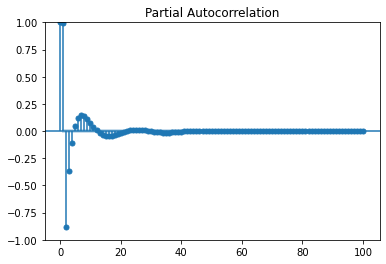

In [306]:
df_stationarityTest = adfuller(signals["ECG_Raw"], autolag='AIC')
print("P-value: ", df_stationarityTest[1])
pacf = plot_pacf(signals["ECG_Raw"], lags=100)

In [308]:

train_data = signals["ECG_Raw"][:len(signals)-5000]
test_data = signals["ECG_Raw"][len(signals)-5000:]

ar_model = AutoReg(train_data, lags=1000).fit()
# print(ar_model.summary())

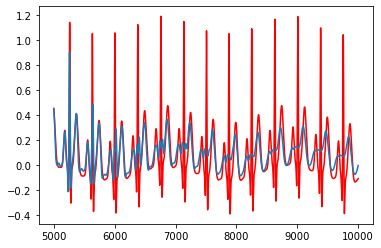

In [309]:

pred = ar_model.predict(start=len(train_data), end=(len(signals)-1), dynamic=False)


plt.plot(test_data, color='red')
plt.plot(pred)

# same process for real ECGs

In [320]:

# load data
file = "physionet.org/files/adfecgdb/1.0.0/r04.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# after normalization 
raw_data = normalize(raw_data,axis=1,norm="max")
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /home/amirsalimi/ECG_Nexting/physionet.org/files/adfecgdb/1.0.0/r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [321]:
ecg = raw_data

train_length = 10000
train = pd.DataFrame(ecg[:,0:train_length].T) # train and validate
test = pd.DataFrame(ecg[:,train_length:].T)

train.columns = ["lead-"+str(x) for x in train.columns]
test.columns = ["lead-"+str(x) for x in test.columns]
train.shape,test.shape

((10000, 5), (290000, 5))

P-value:  1.2351434719931068e-06


/home/amirsalimi/miniconda3/envs/nexting/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


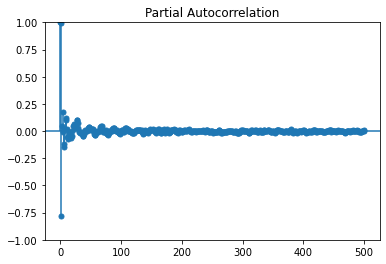

In [322]:
df_stationarityTest = adfuller(train["lead-1"], autolag='AIC')
print("P-value: ", df_stationarityTest[1])
pacf = plot_pacf(train["lead-1"], lags=500)

In [317]:

train_data = train["lead-1"]
test_data = test["lead-1"]
ar_model = AutoReg(train_data.values, lags=1000).fit()
# print(ar_model.summary())

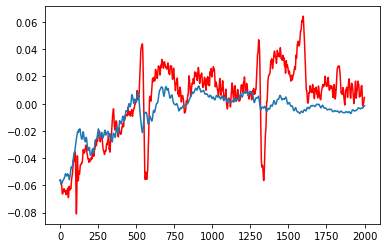

In [325]:
pred_start, pred_length = 10000,5000

pred = ar_model.predict(start=10000, end=12000, dynamic=False)


plt.plot(test_data[:2000], color='red')
plt.plot(pred)

so it works well on real ECGs as well